# Predicting StarCraft II Win Probability - Notebook 1

## Introduction

StarCraft II is a Real-Time Strategy game (RTS) which has been a popular eSport since its release in 2010. The game has progressed through a number of iterations, the most recent being named "Legacy of the Void" (LOTV), which was released in 2015.

### How does the game work?
The game is played on a map by two players (more than two players are possible but the primary focus of the competitive amateur and professional scene is 1 vs 1 games). It is a largely successful game, with around 500,000 players per season at its peak.

![Average Player Population per Season](img\avg-player-population.png)

<center>
<b>Average Player Population per Season</b> (<i>Source: <a href="https://www.rankedftw.com/stats/population/1v1/#v=2&r=-2&sy=c&sx=a">rankedftw.com</a></i>)
</center>

#### What is MMR?
A player will queue up for a "ladder game" (a game against another human competitor), and match-making is performed using MMR (Matchmaking Rating) which is a measure of player skill, similar to ELO in chess. A win or loss in a ladder game is used to update the MMR of both players, with the adjustment being proportional to the initial difference in MMR between the two players (i.e. beating a player with much higher MMR will result in a high adjustment). The MMR range is between 0 and around 7,500. Although there is no technical upper limit for MMR, once a player reaches such high levels, the relative MMR gain per game becomes very small because the MMR difference between other players becomes so large. A player with an MMR around 7,500 will gain only 1 or 2 MMR for a win, but lose as much as 50 or more MMR for a loss, making it difficult to increase their MMR over time.

#### Game setup
Each player chooses one of three races: Protoss, Terran, or Zerg - allowing for a total of 6 possible match-ups. The game begins with a player having 12 worker units and a main base. The basic strategy for the game is outlined by:
* Use workers to mine one of the two resources on the map: Mineral or vespene gas.
* Use workers to construct buildings to create military units, research upgrades, collect more resources, and defend their base.
* Expand bases to new locations on the map. There are typically 5 to 7 bases available for each player to expand to.
* Use military units to attack enemy units, while maintaining economic balance.

#### Winning the game
A game is won when a player has destroyed all enemy buildings. However, games typically end earlier than this as one player concedes when it becomes clear that they can no longer win.

## Goal of the project
The goal of this Jupyter Notebook series is to model the win-probability as the game progresses. This would have 3 major use-cases:
* *Broadcasting*: Professional games are widely broadcast, with the 2019 WCS Global Finals having an average live viewership of 36,430, peak viewership of 80,030 and prize pool of $500,000 (__[source](https://escharts.com/tournaments/sc2/wcs-global-finals-2019)__). An overlay which occasionally updates viewers with the probability of one player winning would be an interesting feature to add, highlighting "big moments" in the game where the win-probability swings from one players favor to the other.
* *Player analysis*: It is common practice for players and professionals to re-watch their own games in order to understand how they performed, and what improvements could be made. This tool would allow for additional insights into which moments were most significant in affecting the outcome of the game, as well as helping players identify where they have conceded too early.
* *AI training*: StarCraft II is already a popular field of study for AI, with Google's __[AlphaStar](https://deepmind.com/blog/article/alphastar-mastering-real-time-strategy-game-starcraft-ii)__ having been trained to the point where it could even defeat professional players. Predicting the probability of victory for a given game state could provide an additional reward metric for training AIs.

In addition to the above, this methodology could also be applied to new games such as Age of Empires, or even popular turn-based strategy games such as Civilization VI.

## Data Sources
Data are sourced from `SC2REPLAY` files which are autogenerated by the game client every time a game is played. StarCraft II is a fully deterministic game, meaning that the replay files simply contain a list of each and every action taken in the game, to find out what happens at any given moment in the game one has to simulate every action up until that point in time.

A python package named __[sc2reader](https://github.com/ggtracker/sc2reader)__ is used to read the replay files, converting each replay into an object with attributes contain both metadata and game events. This package is used in a number of publically available replay analysis tools, as well as tools to analyze the actions most often taken by players in-game.

A replay file contains data at a frame by frame level. Each frame represents 1/16th of an in-game second, and each in-game second is 1/1.4 of a real-time second (i.e. there are 22.4 frames per real-time second).

### Datasets
Two datasets are collected:
* __[Blizzard](https://github.com/Blizzard/s2client-proto#downloads)__: A collection of &pm;1.2 million replays which were are specifically provided by Blizzard (the game developers) for the purpose of training AI agents to play the game. These replay files are anonymized and contain only the actions taken by the players, and not the game state. In this study we use the Blizzard dataset to train a metadata model that attempts to predict the outcome of the game based only on the information available before the game starts. 
* __[SpawningTool](https://lotv.spawningtool.com/replays/)__: 48,479 replay files downloaded from a collection of user-uploaded replay files. These replay files are not anonymized and contain the game state at every moment in the game. In this study we use the SpawningTool dataset to train a neural network that predicts the probability of victory for a player as the game progresses. The dataset is also used as the test data for the Metadata Model.

## Methodology
* **Notebook 1 (this notebook): Data Collection** - Process replay files to extract metadata and game events.
    * Collect data from `SC2REPLAY` files:    
        * *Metadata*: The information about the game, such as the map; player names, races, and MMR; and game outcome, length and region. Metadata for each dataset are stored in a single `csv` file per dataset. Data are collected using `sc2reader` using the `load_level=2` setting to increase speed of replay parsing (each load level increases the amount of detail extracted at the cost of additional processing time and memory).
        * *Event data*: The actions taken by the players in the game, such as the units that were created, the actions taken by the players, their resource collection rates and spending, etc. Game events for each game are stored in a `pkl` file, named after the filehash of the original replay file. This allows easy referencing to a particular game events file from the metadata file.
    * Clean Event Data
        * Create a dataframe from each `pkl` file.
        * Remove all irrelevant actions.
        * Divide game events into actions taken by each player.
        * Store a final dataframe that consists of a single row per frame of the game.
* **Notebook 2: Metadata Analysis** 
    * Visually explore the metadata.
    * Understand the split of player levels, races, regions, etc that are avaialable - particularly in the SpawningTool dataset that will be used to train the neural network.
    * Model the outcome of the game based on metadata alone. Train the model using the Blizzard dataset and test it using the SpawningTool dataset.
* **Notebook 3: Event data Analysis**
    * Visually explore the event data
    * Understand the types of actions that are taken, and create any new features that could be used to improve modeling.
    * Construct and train a Recurrent Neural Network (RNN) to predict the probability of victory for a player as the game progresses.
    * Compare RNN to the Metadata Model to understand if the RNN is an improvement of game understanding.
    * Conclusions and further work to be done.

For Notebook 1 an environment named `sc2` is created in Conda which contains the following required packages:
* `pandas`
* `numpy`
* `scipy`
* `matplotlib`
* `seaborn`
* `scikit-learn`
* `sc2reader`
* `multiprocessing`

For Notebook 2 and 3 a new environment named `tflow` is used:
* `tensorflow`

`yml` files are included in this repository to set up each environment.

---

---

Package imports and settings:


In [1]:
# initial imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sc2reader
import re
import random
import datetime
import json
from scripts.classes import ReplayInfo
import time
import math
import multiprocessing as mp

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# import random forest
from sklearn.ensemble import RandomForestClassifier

# import KNN
from sklearn.neighbors import KNeighborsClassifier

# import grid_search
from sklearn.model_selection import GridSearchCV

# import warnings
import warnings

In [2]:
#### Matplotlib settings
%matplotlib inline
import matplotlib as mpl

# specify default rcParams so that fontsize, weight and style do not need to set
# each time
# Title in bold, fontsize 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20
# Plot fontsize 12 and bold
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 13
# set figure size
mpl.rcParams['figure.figsize'] = (15, 8)

# race list and colors that will be used to represent them
RACE_LIST = [
    'Protoss',
    'Terran',
    'Zerg'
    ]
COLOR_DICT = {
    'Protoss': 'goldenrod',
    'Terran': 'firebrick',
    'Zerg': 'darkviolet'
    }


---

# Data Collection

## Table of Contents


## Section 1: Metdata Collection

This process is broken down into two phases:
1. **Metadata collection** - Extract the metadata from both SpawningTool and Blizzard datasets.
2. **Data cleaning** - Explore the data to determine how much complete information is available. The data should be relatively clean, as duplicates are already removed during replay parsing.

### 1.1 - Processing replay files

o process the metadata, the following steps will be followed:
* A python script `process_replays.py` is written using the ipython magic `%%writefile` to the scripts folder. The separate script enables the use of multiprocessing to greatly improve the speed of execution.
* A replay file is loaded using `load_replay` from the `s2reader` package. Load level 2 is selected as it contains the relevant player and metadata.
* The replay is parsed using the `ReplayInfo` class (found in scripts/classes/replay_info.py, and also written using `%%writefile`).
* The parsed replay is added to a list of replays which is then converted to a pandas dataframe.
* The dataframe is then written to a csv file. Separate csv files are created for SpawningTool and Blizzard replays in the data folder (`spawningtool_replays.csv` and `blizzard_replays.csv` respectively). 

The metadata collected are:
* `Map hash` - this is used in preference to the map name, as different regions have different translations for the same map.
* `Player races`
* `Player MMR` (if available)
* `Player highest league`
* `Game length`
* `Game outcome`
* `Game type` (to ensure that the game is 1v1 instead of a 4 player game etc.)
* `Game speed` (just as an additional check that the game format is correct)
* `Game FPS` (just as an additional check that the game format is correct)
* `Game timestamp`
* `Region` of the game server that the replay was played on
* `Filehash` - this is used to ensure that replays are not duplicated, and as an identifier for event data `pkl` files.
* `Is_ladder` - If the game is a ladder game (again checking that the game format is correct).

#### Script to extract metadata from replay files
A script is written to allow the use of multiprocessing to greatly improve the speed of execution. The settings in `replay_settings.json` allow the user to specify the number of cores that will be used during execution. Setting `n_jobs` to -1 will use all available cores minus one (to prevent locking up when all cores are occupied).

In [ ]:
%%writefile scripts/process_replays.py
"""
This file is used to process replays and extract the data
Tt is used as a separate script to allow for parallel processing
Settings can be found in replay_settings.json
"""
import json
import os
import multiprocessing as mp
import random
import sc2reader
from scripts.classes import ReplayInfo
import pandas as pd
import time

def process_replay(filename):
    """
    process_replay
    ___________________________________________________________________________
    Processes a replay file and returns a ReplayInfo object if the replay is valid according to the filters. Else returns None.

    Args:
        filename (string): Absolute path to the replay file.
        filters (dict): A dictionary of filters to apply to the replay. Dictionary keys are the attributes of ReplayInfo, and values are those that should be excluded.

    Returns:
        [type]: [description]
    """
    # load replay
    try:
        replay = sc2reader.load_replay(
            filename,
            load_level=2 # level 2 is all that is required for metadata
            )
    except: # catch exceptions created by sc2reader
        return None

    try:
        replay_object = ReplayInfo(replay)
    except: # catch exceptions created by ReplayInfo
        return None

    return replay_object

if __name__ == "__main__":

    __spec__ = None # suppress warnings
    
    # start timer
    timer = time.time()

    # load settings
    with open("scripts/replay_settings.json", "r") as f:
        settings = json.load(f)

    # get replay directory from settings
    replay_dir = settings["replay_dir"]

    # get sample size from settings
    sample_size = settings["sample_size"]

    # get n_jobs from settings
    n_jobs = settings["n_jobs"]

    # get output_file from settings
    output_file = settings["output_file"]
    if output_file == "":
        output_file = 'data/replays.csv'

    # get random seed from settings
    # check if random_seed key exists
    if "random_seed" in settings:
        random_seed = settings["random_seed"]
    else:
        random_seed = None

    replays_list = []
    # loop through replay directory and get list of .SC2Replay files
    for dirpath, dirnames, filenames in os.walk(replay_dir):
        for filename in filenames:
            if filename.endswith('.SC2Replay'):
                filepath = os.path.join(dirpath, filename)
                replays_list.append(filepath)

    if sample_size != -1:
        # take a random sample of replays
        random.seed(random_seed)
        replays_list = random.sample(replays_list, sample_size)

    # process replays
    if n_jobs == -1:
        cpu_total = mp.cpu_count()-1
    else:
        cpu_total = n_jobs

    print(f'Processing {len(replays_list)} replays')

    with mp.Pool(processes=cpu_total) as pool:
        replay_collection = pool.map(
            process_replay,
            replays_list
        )

    # remove all None from replay_collection
    replay_collection = [x for x in replay_collection if x is not None]

    # convert replay collection to dataframe
    replay_df = pd.DataFrame({
        'filename':[x.filename for x in replay_collection],
        'map':[x.map_hash for x in replay_collection],
        'player1_race':[x.player_races[0] for x in replay_collection],
        'player2_race':[x.player_races[1] for x in replay_collection],
        'player1_mmr':[x.player_mmrs[0] for x in replay_collection],
        'player2_mmr':[x.player_mmrs[1] for x in replay_collection],
        'game_length':[x.game_length for x in replay_collection],
        'game_type':[x.game_type for x in replay_collection],
        'game_speed':[x.game_speed for x in replay_collection],
        'game_winner':[x.game_winner for x in replay_collection],
        'timestamp':[x.timestamp for x in replay_collection],
        'fps':[x.fps for x in replay_collection],
        'is_ladder':[x.is_ladder for x in replay_collection],
        'region':[x.region for x in replay_collection],
        'player1_highest_league':[
            x.highest_league[0] for x in replay_collection
        ],
        'player2_highest_league':[
            x.highest_league[1] for x in replay_collection
        ],
        'filehash':[x.filehash for x in replay_collection]
    })

    # remove rows with duplicate filehashes
    replay_df = replay_df.drop_duplicates(subset='filehash')

    # write replay_collection to csv with no index
    replay_df.to_csv(output_file, index=False)

    # found x valid replays
    print(f'Found {replay_df.shape[0]} unique valid replays')
    # print time elapsed as HH:MM:SS
    print(f'Time elapsed: {time.strftime("%H:%M:%S", time.gmtime(time.time() - timer))}')


Overwriting scripts/process_replays.py


#### Class definition for ReplayInfo
This class is used to parse the replay files and extract the metadata to more easily convert it into a pandas dataframe.

In [30]:
%%writefile scripts/classes/ReplayInfo.py
"""
Classes used in the analysis of replays.

Current list:
    - ReplayInfo - Extract metadata from replay files. (e.g. map, player names, etc.)
"""
import re

class ReplayInfo:

    def __init__(self, replay):
        # self.__Replay = replay
        self.map_hash = replay.map_hash
        self.player_races = self._get_player_races(replay)
        self.filename = replay.filename
        self.player_mmrs = self._get_player_mmrs(replay)
        self.game_length = self._get_game_length(replay)
        self.game_winner = self._get_winner(replay)
        self.timestamp = replay.unix_timestamp
        self.game_type = replay.type
        self.game_speed = replay.speed
        self.fps = replay.game_fps
        self.is_ladder = replay.is_ladder
        self.region = replay.region
        self.highest_league = self._get_player_highest_league(replay)
        self.filehash = replay.filehash


    def _get_game_length(self, replay):

        # this converts to minutes.seconds
        length_string = str(replay.game_length)

        # use regex to extract all numbers from length_string
        minutes = length_string.split('.')[0]
        seconds = length_string.split('.')[1]

        # convert to int in seconds
        return int(minutes)*60 + int(seconds)


    def _get_winner(self, replay):

        winner_string = str(replay.winner)
        if 'Player 1' in winner_string:
            return 1
        elif 'Player 2' in winner_string:
            return 2
        else:
            return 0


    def _get_player_highest_league(self, replay):

        str_a = 'replay.initData'
        str_b = 'user_initial_data'
        str_c = 'highest_league'

        # check that replay.initData exists in key
        if str_a not in replay.raw_data.keys():
            str_a = 'replay.initData.backup'

        return (
            replay.raw_data[str_a][str_b][0][str_c],
            replay.raw_data[str_a][str_b][1][str_c]
            )


    def _get_player_mmrs(self, replay):

        str_a = 'replay.initData'
        str_b = 'user_initial_data'
        str_c = 'scaled_rating'

        # check that replay.initData exists in key
        if str_a not in replay.raw_data.keys():
            str_a = 'replay.initData.backup'

        return (
            replay.raw_data[str_a][str_b][0][str_c],
            replay.raw_data[str_a][str_b][1][str_c]
            )


    # get the player races
    def _get_player_races(self, replay):
        """
        _get_player_races
        Iterate through players in self.__Replay.players and extract player
        races as strings from the info

        Returns:
            tuple - Length 2 contain the races of both players
        """

        player_string = []

        for player in replay.players:
            # convert player to string
            player_string.append(str(player))


        return (
            self._get_race(player_string[0]),
            self._get_race(player_string[1])
            )


    def _get_race(self, player):
        """
        _get_race Extract race from string. String is assumed to be of the form:
        'Player x - Race'.

        Args:
            player (str): A string of form 'Player x - Race'

        Returns:
            str: Race of the player
        """

        RACE_LIST = [
            'Protoss',
            'Terran',
            'Zerg'
        ]

        # assert that player is a string
        assert isinstance(player, str), 'player should be a string'


        for race in RACE_LIST:

            race_string = '('+race+')'

            if race_string.lower() in player.lower():

                # assert that race_string is in player
                assert race_string in player, \
                    f'{player} does not adhere to to {race_string} formatting'
                # use replace to delete the player race
                player = player.replace(race_string, '')

                # create regex to find 'Player 1 - ' leaving only actual name
                reg_str = r'Player\s\d\s\-\s'

                # assert that reg_str is in player string
                assert re.search(reg_str, player), \
                    f'{player} does not adhere to to {reg_str} formatting'

                return race

Overwriting scripts/classes/ReplayInfo.py


Now that the process for extracting the metadata is defined, the script can be run using the `%%run` magic. For each of the two runs, only the `replay_settings.json` file found in the scripts folder need be modified.

#### Extract SpawningTool metadata
This script took approximately 1 minute to run on a 6 core machine.

In [5]:
# specify json settings in scripts/replay_settings.json
replay_settings = {
    "replay_dir": "data/SpawningTool",
    "sample_size": -1,
    "n_jobs": -1,
    "output_file": "data/spawningtool_replays.csv"
}

# write json settings to file
with open("scripts/replay_settings.json", "w") as file:
    json.dump(replay_settings, file, indent=4)

# run the script to extract metadata from replays
%run ./scripts/process_replays.py 

Processing 48479 replays
Found 36812 unique valid replays
Time elapsed: 00:01:00


In [37]:
# inspect the dataframe
df = pd.read_csv('data/spawningtool_replays.csv')
display(df)

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,data/SpawningTool/Other/page1/2-liberator-tank...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Protoss,-36400.0,NaN,402,1v1,Normal,1,1633598712,16.0,False,us,4,0,9384fda8c370ea7d130ac20244f7d0fda9a9b834004445...
1,data/SpawningTool/Other/page1/2-liberators-1-t...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Zerg,-36400.0,NaN,371,1v1,Normal,1,1633603684,16.0,False,us,4,0,f9864054498acf297aacf2be80896ba131716a341983de...
2,data/SpawningTool/Other/page1/2000-atmospheres...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Zerg,Zerg,4022.0,3502.0,371,1v1,Faster,1,1633788999,16.0,True,eu,6,6,178a82fa5045e82a3920688274d7a524595f0ef6dc91ae...
3,data/SpawningTool/Other/page1/2021-09-05-zserr...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,NaN,NaN,1803,1v1,Faster,1,1630608640,16.0,False,eu,7,6,99ba80721116d18f965c141581baa878abf02526f48bc6...
4,data/SpawningTool/Other/page1/2021-10-01-zvaev...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,3615.0,3567.0,502,1v1,Faster,1,1633138764,16.0,True,us,5,5,b9e96a1dabcc0de0cfd89e8f0d02b5b8e064ec3f3c07c1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36807,data/SpawningTool/Pro/page973/zvp-5.SC2Replay,5bcae311df60fac557b25c2889f26a9d10bb602f2a34d7...,Zerg,Protoss,NaN,NaN,804,1v1,Faster,2,1427952943,16.0,True,xx,8,8,86edadabea6cede88a70ed9102e0d45cdea7850d23ade8...
36808,data/SpawningTool/Pro/page973/zvp-6.SC2Replay,27675af51780a8617d291dcb8322c98e316ca8f753c6cf...,Protoss,Zerg,NaN,NaN,381,1v1,Faster,1,1427953453,16.0,True,xx,8,8,42930fdc21561395bcefc960b2d5525f7b6adf11dc0eab...
36809,data/SpawningTool/Pro/page973/zvp.SC2Replay,b588030794f4d6f2b6eac01b50a97dd94a93169a137632...,Zerg,Protoss,NaN,NaN,1272,1v1,Faster,2,1427949111,16.0,True,xx,8,8,8d1c2a7a406cdedfdd8db8ae24968b16edfde4c1a38230...
36810,data/SpawningTool/Pro/page973/zvt-2.SC2Replay,b588030794f4d6f2b6eac01b50a97dd94a93169a137632...,Zerg,Terran,NaN,NaN,957,1v1,Faster,1,1427954447,16.0,True,xx,8,8,d6430bacdb3bc5a22e09d445655486cb06cf7e9d23b479...


#### Extract Blizzard metadata
This script took approximately 16 minutes to run on a 6 core machine.

In [3]:
# specify json settings in scripts/replay_settings.json
replay_settings = {
    "replay_dir": "data/Blizzard",
    "sample_size": -1,
    "n_jobs": -1,
    "output_file": "data/blizzard_replays.csv"
}

# write json settings to file
with open("scripts/replay_settings.json", "w") as file:
    json.dump(replay_settings, file, indent=4)

# run the script to extract metadata from replays
%run ./scripts/process_replays.py 

Processing 1225046 replays
Found 1203339 unique valid replays
Time elapsed: 00:16:05


In [36]:
# inspect the dataframe
df = pd.read_csv('data/blizzard_replays.csv')
display(df)

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,data/Blizzard/set_1/0000e057beefc9b1e9da959ed9...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Protoss,Zerg,5402,5564,932,1v1,Faster,2,1502208724,16.0,True,eu,6,6,9706f355243444e1666cd19a3a6cc1a315957e885f2ded...
1,data/Blizzard/set_1/0002b71a92623234bf67fac85e...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Terran,Terran,3882,3951,324,1v1,Faster,1,1502197141,16.0,True,eu,5,5,e60e9fcdde514415eb2466ceab3c7d23af2b4549d74e89...
2,data/Blizzard/set_1/0002c4f2d94ba7aaf2f71b9d8c...,be0af789b8cef0379fd32602b5730096bb0b0138fe7aba...,Terran,Zerg,4088,3365,667,1v1,Faster,2,1502280613,16.0,True,eu,5,0,82f4f6bf5d2c0af9b5a8f5c0c9606a0dc6819b09ae9a7a...
3,data/Blizzard/set_1/000309f32db5b1e65312208cca...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Zerg,Terran,3234,3063,775,1v1,Faster,1,1502262699,16.0,True,cn,3,3,2cc2384ffd09b3f6a63aa4fd2223db082dad6917c0f3b6...
4,data/Blizzard/set_1/000484de77e46af60af75a20b8...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Zerg,Zerg,4254,4121,537,1v1,Faster,1,1502290022,16.0,True,us,5,5,537f1b82a364599638da021fabb2c9d975c94ca2f59eb7...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203334,data/Blizzard/set_2/ffffdbb8fc30435e69a1fe20d9...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,NaN,NaN,2780,2314,428,1v1,Faster,2,1503455719,16.0,True,eu,1,0,b8044f1380c12d222459208e846aecf620313e4e081d7b...
1203335,data/Blizzard/set_2/fffff0871993994afd8ef921f0...,8e8a27bc43f7c310705c16e4a564f64f228bf17085aaf9...,Zerg,Terran,3277,3340,338,1v1,Faster,1,1501307715,16.0,True,eu,3,4,3307446025ff8031b6bb7d1dd3aec6b8fd85a12284281c...
1203336,data/Blizzard/set_2/fffff6ab18bdfbf9afd9a672a1...,8e8a27bc43f7c310705c16e4a564f64f228bf17085aaf9...,Terran,Protoss,5638,5479,500,1v1,Faster,2,1501283007,16.0,True,us,6,6,983c2a9b2003480188f19c976426ea468a4a619763eb51...
1203337,data/Blizzard/set_2/fffff7acc07773147979f493ab...,c3df4517b78fb0c6042f76667341403faf9b0fc479548f...,Terran,Terran,4536,4522,630,1v1,Faster,2,1502044421,16.0,True,us,5,5,5c029414352f98f3a0615bc3b3b26ca3df26ad8f8905fb...


### 1.2 - Metadata cleaning
Metadata will be used for modeling the outcome of the game. It is expected that the most important features will relate to player MMRs, and races. The completeness of these components will be checked.

This step will not make any changes to the data stored in the `csv` files, but will rather be used as a template to create a function that can be imported in Notebook 2 to clean the data as needed, before it is used in the modeling.

#### Correct filenames
The filenames in the `csv` are constructed with inconsistent forward- and backslashes. While these may still 
work correctly, it may be worth updating these filenames to use the correct forwardslash at this point.

In [4]:
def correct_slash_direction(df):
    """
    correct_slash_direction
    Inspect file paths in the filename column of the supplied dataframe and 
    correct the slash direction to standard forwardslash.

    Args:
        df (pandas.DataFrame): A pandas dataframe with a filename column

    Returns:
        pandas.DataFrame: A pandas dataframe with the corrected file paths
    """    

    # assert that df is a dataframe
    assert isinstance(df, pd.DataFrame), 'df should be a dataframe'

    # assert that filename column exists
    assert 'filename' in df.columns, 'df should have a filename column'

    # assert that filename column is a string
    assert isinstance(df['filename'][0], str), \
        'filename column should be a string'

    # correct \\ and \ to / in filename column
    # first check for \\ and then check for \
    df['filename'] = df['filename'].apply(lambda x: x.replace('\\\\', '/'))
    df['filename'] = df['filename'].apply(lambda x: x.replace('\\', '/'))

    return df

In [5]:
# correct SpawningTool dataframe and update the csv file
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')
spawningtool_df = correct_slash_direction(spawningtool_df)
spawningtool_df.to_csv('data/spawningtool_replays.csv', index=False)

# correct Blizzard dataframe and update the csv file
blizzard_df = pd.read_csv('data/blizzard_replays.csv')
blizzard_df = correct_slash_direction(blizzard_df)
blizzard_df.to_csv('data/blizzard_replays.csv', index=False)

#### Inspect the dataframes

In [6]:
print("The shape of the SpawningTool dataframe is", spawningtool_df.shape)
print("The shape of the Blizzard dataframe is    ", blizzard_df.shape)

The shape of the SpawningTool dataframe is (36812, 17)
The shape of the Blizzard dataframe is     (1203339, 17)


The inspections will be the same for both datasets. We have 36,812 records in the SpawningTool dataset, and 1,203,339 records in the Blizzard dataset, with both datasets containing a total of 17 features.

#### Identify amount of missing data

In [7]:
print("Fraction of missing values in SpawningTool dataframe:")
spawningtool_df.isna().sum()/spawningtool_df.shape[0]

Fraction of missing values in SpawningTool dataframe:


filename                  0.000000
map                       0.000000
player1_race              0.012333
player2_race              0.012333
player1_mmr               0.700532
player2_mmr               0.701782
game_length               0.000000
game_type                 0.000000
game_speed                0.000000
game_winner               0.000000
timestamp                 0.000000
fps                       0.000000
is_ladder                 0.000000
region                    0.000000
player1_highest_league    0.000000
player2_highest_league    0.000000
filehash                  0.000000
dtype: float64

In [8]:
print("Fraction of missing values in Blizzard dataframe:")
blizzard_df.isna().sum()/blizzard_df.shape[0]

Fraction of missing values in Blizzard dataframe:


filename                  0.000000
map                       0.000000
player1_race              0.053712
player2_race              0.053712
player1_mmr               0.000000
player2_mmr               0.000000
game_length               0.000000
game_type                 0.000000
game_speed                0.000000
game_winner               0.000000
timestamp                 0.000000
fps                       0.000000
is_ladder                 0.000000
region                    0.000000
player1_highest_league    0.000000
player2_highest_league    0.000000
filehash                  0.000000
dtype: float64

The SpawningTool dataset appears to contain a large amount of missing MMR data, which is unfortunate, as MMR is a key component that would be used in metadata modeling. However, the primary purpose of this dataset is to train the neural network, and for that only the event data is required.

As a secondary check, let us define a valid MMR range and check the amount of replays in both datasets that would be considered valid.
* Minimum MMR: 2,000 - This value is selected as below this MMR range a player would be in "Bronze" league, and likely very new to the game. Their actions may not be as relevant to predicting the outcome of the game, and may confuse the model.
* Maximum MMR: 8,000 - The maximum MMR is selected as 8,000 as this should include all games. The top players in all regions tend to have MMRs of 7,500 and below.

We will perform a quick check on the MMR ranges to confirm the above assumptions are valid.

In [9]:
# get the max and min MMR for each region for SpawningTool
spawningtool_df.groupby('region')[
    ['player1_mmr', 'player2_mmr']
].agg(['max', 'min'])

player1_mmr          player2_mmr         
               max      min         max      min
region                                          
cn          5828.0 -36400.0      6141.0 -36400.0
eu          7372.0 -36400.0      7416.0 -36400.0
kr          6883.0 -36400.0      6830.0 -36400.0
sea            NaN      NaN         NaN      NaN
us          6591.0 -36400.0      6798.0 -36400.0
xx             NaN      NaN         NaN      NaN

In [10]:
# get the max and min MMR for each region for Blizzard
blizzard_df.groupby('region')[
    ['player1_mmr', 'player2_mmr']
].agg(['max', 'min'])


player1_mmr        player2_mmr       
               max    min         max    min
region                                      
cn            6299 -36400        6922 -36560
eu            6901 -36560        7271 -36926
kr            6984 -36560        7020 -36786
us            6874 -36560        6990 -36560

Both datasets appear to have minimum MMRs that are negative, indicating some error in the data. This will be cleaned by specifying the minimum MMR range. The maximum MMR range of 8,000 appears to be reasonable, as the highest in either dataset is 7,416.

In [11]:
# min and max values for MMR
min_mmr, max_mmr = 2000, 8000

# count the number of replays with both players MMRs between min and max

print("The number of valid MMR replays in SpawningTool is", 
    spawningtool_df[
        (spawningtool_df['player1_mmr'] >= min_mmr) &
        (spawningtool_df['player1_mmr'] <= max_mmr) &
        (spawningtool_df['player2_mmr'] >= min_mmr) &
        (spawningtool_df['player2_mmr'] <= max_mmr)
    ].shape[0]
)

print("The number of valid MMR replays in Blizzard is  ", 
    blizzard_df[
        (blizzard_df['player1_mmr'] >= min_mmr) &
        (blizzard_df['player1_mmr'] <= max_mmr) &
        (blizzard_df['player2_mmr'] >= min_mmr) &
        (blizzard_df['player2_mmr'] <= max_mmr)
    ].shape[0]    
)


The number of valid MMR replays in SpawningTool is 10162
The number of valid MMR replays in Blizzard is   1165910


Only &pm;10,000 replays from SpawningTool have valid MMRs (28% of 36,812), with 1,165,910 replays from Blizzard having valid MMRs (97% of 1,203,339). Because the valid SpawningTool replays is such a small fraction of the Blizzard dataset (&pm;1%), we will use some Blizzard data to test as well as train the Metadata model, and then use the SpawningTool data as a supplementary test set.

#### Missing race data
It is worth noting that &pm;5% of the Blizzard data and &pm;1% of the SpawningTool data are missing race data for the players. This is peculiar, but it may be caused by player who play as "random".

Random players are players who, instead of choosing a single race to play with, are randomly assigned a race at the beginning of each match. 

It may be possible to impute this missing data from event data for the SpawningTool data, for Blizzard data these replays will be dropped wherever race is used in modeling.

#### Final checks on data quality
The pandas `describe()` method will be used to determine the value ranges for all numerical data both datasets, to potentially identify abnormal values that may not be NaN (much like the negative MMR values).

Categorical columns (`race`, `game_type`, `map`  and `region`) will be inspected using the pandas `value_counts()` method.

In [12]:
print("<<<< SpawningTool Numerical Data >>>>")
# use describe to get the mean, std, min, max, and count of each column
# use an apply function to get the values in readable format
# as suggested here: 
# https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation
display(spawningtool_df.describe().T.apply(lambda x: x.map('{:,.2f}'.format)))

print("\u2500" * 80)
print("<<<< Blizzard Numerical Data >>>>")
display(blizzard_df.describe().T.apply(lambda x: x.map('{:,.2f}'.format)))

<<<< SpawningTool Numerical Data >>>>


,count,mean,std,min,25%,50%,75%,max
player1_mmr,"11,024.00","2,297.50","7,008.45","-36,400.00","2,716.00","3,184.00","4,066.00","7,372.00"
player2_mmr,"10,978.00","2,472.88","6,505.29","-36,400.00","2,738.00","3,182.00","4,078.75","7,416.00"
game_length,"36,812.00",708.34,358.35,0.00,472.00,653.00,880.00,"3,552.00"
game_winner,"36,812.00",1.38,0.59,0.00,1.00,1.00,2.00,2.00
timestamp,"36,812.00","1,553,203,249.69","52,457,726.74","1,401,465,118.00","1,519,662,179.75","1,563,111,735.50","1,594,694,470.75","1,634,008,784.00"
fps,"36,812.00",16.00,0.00,16.00,16.00,16.00,16.00,16.00
player1_highest_league,"36,812.00",2.73,2.92,0.00,0.00,2.00,6.00,8.00
player2_highest_league,"36,812.00",2.88,2.93,0.00,0.00,2.00,6.00,8.00


────────────────────────────────────────────────────────────────────────────────
<<<< Blizzard Numerical Data >>>>


,count,mean,std,min,25%,50%,75%,max
player1_mmr,"1,203,339.00","3,647.70","1,692.64","-36,560.00","3,190.00","3,628.00","4,129.00","6,984.00"
player2_mmr,"1,203,339.00","2,670.85","6,456.05","-36,926.00","3,174.00","3,622.00","4,126.00","7,271.00"
game_length,"1,203,339.00",658.05,429.60,0.00,362.00,631.00,895.00,"3,596.00"
game_winner,"1,203,339.00",1.49,0.51,0.00,1.00,1.00,2.00,2.00
timestamp,"1,203,339.00","1,502,451,556.91","2,409,097.84","997,941,480.00","1,501,808,938.50","1,502,473,096.00","1,503,132,401.50","1,510,862,330.00"
fps,"1,203,339.00",16.00,0.00,16.00,16.00,16.00,16.00,16.00
player1_highest_league,"1,203,339.00",3.76,1.75,0.00,3.00,4.00,5.00,7.00
player2_highest_league,"1,203,339.00",3.67,1.85,0.00,3.00,4.00,5.00,7.00


In [13]:
categorical_columns = [
    'player1_race',
    'player2_race',
    'game_type',
    'game_speed',
    'is_ladder',
    'region'
]

# perform value_counts for categorical_columns
print('<<<< SpawningTool Category Counts >>>>')
for col in categorical_columns:
    display(spawningtool_df[col].value_counts())


print('\u2500' * 80)
print('<<<< Blizzard Category Counts >>>>')
for col in categorical_columns:
    display(blizzard_df[col].value_counts())


<<<< SpawningTool Category Counts >>>>


Zerg       13426
Protoss    11658
Terran     11274
Name: player1_race, dtype: int64

Zerg       12893
Terran     11748
Protoss    11717
Name: player2_race, dtype: int64

1v1    33390
2v2     2643
3v3      581
4v4      170
FFA       26
6v6        1
5v5        1
Name: game_type, dtype: int64

Faster    36646
Slower       68
Normal       63
Slow         25
Fast         10
Name: game_speed, dtype: int64

False    23589
True     13223
Name: is_ladder, dtype: int64

eu     14991
us     13934
xx      4225
kr      2628
cn      1033
sea        1
Name: region, dtype: int64

────────────────────────────────────────────────────────────────────────────────
<<<< Blizzard Category Counts >>>>


Terran     452683
Zerg       373177
Protoss    312845
Name: player1_race, dtype: int64

Terran     444553
Zerg       374995
Protoss    319157
Name: player2_race, dtype: int64

1v1    1203339
Name: game_type, dtype: int64

Faster    1203339
Name: game_speed, dtype: int64

True    1203339
Name: is_ladder, dtype: int64

eu    434310
us    342204
kr    225291
cn    201534
Name: region, dtype: int64

As would be expected (because SpawningTool is user-uploaded vs Blizzard being a constructed dataset) there are far more irregularities in SpawningTool data than in Blizzard data. At this point the filtering function will be constructed, and a data clean up simulated to test how many replays are removed from the each dataset.

The initial rules that will be used to filter the data are laid out below. The validity of the rules will be further explored in Notebook 2 during data exploration:
* *The game should have a minimum length of 5 minutes* (300 in-game seconds) to be considered valid. This is because the first 5 minutes of the game is what will be used to train the initial neural network. Also, a game shorter than 5 minutes is likely to be what is called "cheese", i.e. a game where a player deliberately departs from the accepted opening moves in order to throw their opponent off balance.
* *The game should have a maximum length of 45 minutes* (2,700 in-game seconds) to be considered valid. Games of 45 minutes are considered to be very long games, and are likely not to be representative of the game states that the neural network will be attempting to learn.
* *Both players should have MMRs between 2,000 and 8,000* to be considered valid, as discussed above.
* *Both players should have valid races* to be considered valid. If this is found to overly affect the number of replays available in Notebook 2, then possible imputation from event data will be considered.
* *The game should be a 1v1 game* (2 players) to be considered valid. 1v1 games are the most common game format, and the exclusive format used in the professional circuit, games with more players are likely to confuse the neural network, without adding additional value.
* *Region should be one of the following: "eu", "us", "kr", or "cn"* These are the primary server regions for StarCraft II (Europe, North America, Korea, and China respectively).
* *fps should be 16* All replays appear to be played at 16 FPS, but this specification will be added to the model to allow for more flexibility in the future.
* *is_ladder* Initially only True will be allowed, as ladder games are the official format for competitive games. However, because only &pm;10,000 of SpawningTool replays are ladder games, this may need to be reassessed if more data are required for neural network training.
* *game_speed* This should be "faster" which is the default game speed for competitive games (i.e. 1.4 in-game seconds per real-time second).

`%%writefile` will be used to write the filtering function to a file, which will be imported in Notebook 2. The script will be stored in the scrips folder.

In [14]:
%%writefile scripts/filter_replays.py
"""
This script contains the function filter_replays that can be used to filter replays in a dataframe according to a specified (or default) set of criteria.

A number of supporting functions are also included, these can be identified by an underscore at the beginning of the function name.
"""
import pandas as pd
import numpy as np

def _check_filter_inputs(filter_dict):
    """
    check_filter_inputs
    Check the input filters to ensure they are all in the correct format.

    Args:
        filter_dict (dict): A dictionary containing the filter criteria

    Returns:
        None
    """

    # assert that 'df' is a dataframe
    assert isinstance(filter_dict['df'], pd.DataFrame), \
        'df should be a dataframe'
    
    # assert that all bool values are True or False
    bool_keys = [
        'check_game_length',
        'check_player_mmr',
        'check_player_race',
        'check_1v1',
        'check_region',
        'check_fps',
        'check_is_ladder',
        'check_game_speed'
    ]
    for k in bool_keys:
        assert isinstance(filter_dict[k], bool), \
            f"{k} should be a boolean (True or False)"

    # assert that valid regions is a list of strings
    assert isinstance(filter_dict['valid_regions'], list), \
        'valid_regions should be a list of strings'
    for v in filter_dict['valid_regions']:
        assert isinstance(v, str), \
            'valid_regions should be a list of strings'

    # assert that numeric values are positive ints
    numeric_keys = [
        'min_game_length',
        'max_game_length',
        'min_player_mmr',
        'max_player_mmr'
    ]
    for k in numeric_keys:
        assert isinstance(filter_dict[k], int), \
            f"{k} should be a positive integer"
        assert filter_dict[k] > 0, \
            f"{k} should be a positive integer"


def _check_game_length(df, min_game_length, max_game_length):
    """
    check_game_length
    Check the game length of a replay.

    Args:
        df (pandas.DataFrame): A dataframe containing replay data
        min_game_length (int): The minimum game length
        max_game_length (int): The maximum game length

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # get the length of the dataframe
    original_length = df.shape[0]

    # remove rows where the game length is outside the specified range
    df = df[
        (df["game_length"] >= min_game_length) &
        (df["game_length"] <= max_game_length)
    ]

    # print the number of replays that were filtered
    print(f"Game Length: {original_length - df.shape[0]} replays were filtered")

    return df


def _check_player_mmr(df, min_player_mmr, max_player_mmr):
    """
    check_player_mmr
    Check the MMR of both players is valid.

    Args:
        df (pandas.DataFrame): A dataframe containing replay data
        min_player_mmr (int): The minimum player MMR
        max_player_mmr (int): The maximum player MMR

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # get the length of the dataframe
    original_length = df.shape[0]

    # remove rows where the player MMR is outside the specified range
    df = df[
        (df["player1_mmr"] >= min_player_mmr) &
        (df["player1_mmr"] <= max_player_mmr) &
        (df["player2_mmr"] >= min_player_mmr) &
        (df["player2_mmr"] <= max_player_mmr)
    ]

    # print the number of replays that were filtered
    print(f"Player MMR: {original_length - df.shape[0]} replays were filtered")

    return df


def _check_player_races(df):
    """
    _check_player_races
    Check that both players are either Protoss, Terran or Zerg

    Args:
        df (pandas.DataFrame): A dataframe containing replay data

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # get the length of the dataframe
    original_length = df.shape[0]

    # define valid races
    valid_races = [
        'Protoss',
        'Terran',
        'Zerg'
    ]

    # check that both player1_race and player2_race are in valid_races
    df = df[df['player1_race'].isin(valid_races)]
    df = df[df['player2_race'].isin(valid_races)]

    # print the number of replays that were filtered
    print(f"Player Race: {original_length - df.shape[0]} replays were filtered")

    return df


def _check_region(df, regions):
    """
    _check_region
    Check that both players are either Protoss, Terran or Zerg

    Args:
        df (pandas.DataFrame): A dataframe containing replay data
        regions (list): A list of regions to check for

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # get the length of the dataframe
    original_length = df.shape[0]

    # check that region is in regions
    df = df[df['region'].isin(regions)]

    # print the number of replays that were filtered
    print(f"Region: {original_length - df.shape[0]} replays were filtered")

    return df


def _check_other_booleans(df, bools):
    """
    _check_other_boolean
    Check relevant values for all other "check_" options. For each option a relevant value is created to be checked for.

    Args:
        bools (list): A list of booleans to check

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # construct a list of tuples for each boolean
    # tuple contains:
    #   - the name of the boolean
    #   - relevant column in the df
    #   - the relevant value to check against
    bool_checks = [
        ('check_1v1', 'game_type', '1v1'),
        ('check_fps', 'fps', 16.0),
        ('check_is_ladder', 'is_ladder', True),
        ('check_game_speed', 'game_speed', 'Faster'),
    ]

    for i, check in enumerate(bool_checks):
        # get the length of the dataframe
        original_length = df.shape[0]

        # check if bools[i] is True
        if bools[i]:
            # filter the dataframe based on the relevant column and value
            col = check[1]
            val = check[2]
            df = df[df[col] == val]

            # print the number of replays that were filtered
            print(f"{check[0].capitalize()}: {original_length - df.shape[0]} replays were filtered")

    return df


def filter_replays(
    df,
    check_game_length=True,
    min_game_length=int(5*60),
    max_game_length=int(45*60),
    check_player_mmr=True,
    min_player_mmr=2000,
    max_player_mmr=8000,
    check_player_races=True,
    check_1v1=True,
    check_region=True,
    valid_regions=['eu', 'us', 'kr', 'cn'],
    check_fps=True,
    check_is_ladder=True,
    check_game_speed=True
):
    """
    filter_replays
    Filter replays based on the specified options. Prints the number of replays that were filtered at each step, and returns a filtered dataframe.

    Args:
        df (pandas.Dataframe): The dataframe containing replay data to filter
        check_game_length (bool, optional): Whether game length should be checked.
        If True, min_game_length and max_game_length are used. Defaults to True.
        min_game_length (int, optional): Minimum game length in seconds. 
        Defaults to int(5*60) or 5 minutes.
        max_game_length (int, optional): Maximum game length in seconds. 
        Defaults to int(45*60) or 45 minutes.
        check_player_mmr (bool, optional): Whether player MMR should be checked.
        If True, min_player_mmr and max_player_mmr are used. Defaults to True.
        min_player_mmr (int, optional): Minimum valid player MMR. Defaults to 2000.
        max_player_mmr (int, optional): Maximum valid player MMR. Defaults to 8000.
        check_player_races (bool, optional): Whether player races should be checked.
        If True player races should be "Protoss", "Terran" or "Zerg". Defaults to True.
        check_1v1 (bool, optional): Whether game_type should be 1v1. Defaults to True.
        check_region (bool, optional): Whether game_region should be checked. 
        If True, valid_regions is used. Defaults to True.
        valid_regions (list, optional): List of regions that will be considered valid. 
        Defaults to ['eu', 'us', 'kr', 'cn'].
        check_fps (bool, optional): If True only replays with FPS of 16 will be returned.
        Defaults to True.
        check_is_ladder (bool, optional): If True only replays with is_ladder = True are returned. 
        Defaults to True.
        check_game_speed (bool, optional): If true only replays where game_speed is "faster are returned.
        Defaults to True.

    Returns:
        pandas.DataFrame: The filtered dataframe
    """    
    
    # add all arguments to the filter_dict for validation
    filter_dict = {
        'df': df,
        'check_game_length': check_game_length,
        'min_game_length': min_game_length,
        'max_game_length': max_game_length,
        'check_player_mmr': check_player_mmr,
        'min_player_mmr': min_player_mmr,
        'max_player_mmr': max_player_mmr,
        'check_player_race': check_player_races,
        'check_1v1': check_1v1,
        'check_region': check_region,
        'valid_regions': valid_regions,
        'check_fps': check_fps,
        'check_is_ladder': check_is_ladder,
        'check_game_speed': check_game_speed
    }

    # run asserts to ensure that the filter_dict is valid
    _check_filter_inputs(filter_dict)

    # print the length of the dataframe before filtering
    print(f"Length of dataframe before filtering: {df.shape[0]}")

    # filter by game length if check_game_length is True
    if check_game_length:
        df = _check_game_length(df, min_game_length, max_game_length)

    # filter by player mmr if check_player_mmr is True
    if check_player_mmr:
        df = _check_player_mmr(df, min_player_mmr, max_player_mmr)

    # filter by player race if check_player_race is True
    if check_player_races:
        df = _check_player_races(df)

    # filter by region if check_region is True
    if check_region:
        df = _check_region(df, valid_regions)

    # filter by other booleans
    df = _check_other_booleans(
        df,
        [
            check_1v1, 
            check_fps, 
            check_is_ladder, 
            check_game_speed
        ]
    )

    return df

Overwriting scripts/filter_replays.py


In [15]:
from scripts.filter_replays import filter_replays

# test cleaning of SpawningTool metadata
spawningtool_clean = filter_replays(spawningtool_df)
print('\u2500' * 80)
print(f"Length of SpawningTool dataframe after filtering: {spawningtool_clean.shape[0]}")

Length of dataframe before filtering: 36812
Game Length: 2996 replays were filtered
Player MMR: 24688 replays were filtered
Player Race: 125 replays were filtered
Region: 0 replays were filtered
Check_1v1: 2799 replays were filtered
Check_fps: 0 replays were filtered
Check_is_ladder: 0 replays were filtered
Check_game_speed: 0 replays were filtered
────────────────────────────────────────────────────────────────────────────────
Length of SpawningTool dataframe after filtering: 6204


In [16]:
# test cleaning of Blizzard metadata
blizzard_clean = filter_replays(blizzard_df)
print('\u2500' * 80)
print(f"Length of Blizzard dataframe after filtering: {blizzard_clean.shape[0]}")

Length of dataframe before filtering: 1203339
Game Length: 235673 replays were filtered
Player MMR: 27973 replays were filtered
Player Race: 52406 replays were filtered
Region: 0 replays were filtered
Check_1v1: 0 replays were filtered
Check_fps: 0 replays were filtered
Check_is_ladder: 0 replays were filtered
Check_game_speed: 0 replays were filtered
────────────────────────────────────────────────────────────────────────────────
Length of Blizzard dataframe after filtering: 887287


Only 6,204 replays from SpawningTool survived the filtering.

 This is a worryingly small fraction of the original dataset. In training the neural network, this small dataset will be used for initial training, but it is possible that it may be necessary to remove the MMR filter requirement in order to have enough data to both test and train the model.

Removing the MMR filter for SpawningTool is tested below. The `is_ladder` filter is also removed as it is likely that games without MMR are non-ladder games.

In [18]:
# test cleaning of SpawningTool metadata without the MMR check
spawningtool_clean = filter_replays(
    spawningtool_df, 
    check_player_mmr=False,
    check_is_ladder=False)
print('\u2500' * 80)
print(f"Length of SpawningTool dataframe after filtering without MMR requirement: {spawningtool_clean.shape[0]}")

Length of dataframe before filtering: 36812
Game Length: 2996 replays were filtered
Player Race: 424 replays were filtered
Region: 3897 replays were filtered
Check_1v1: 3131 replays were filtered
Check_fps: 0 replays were filtered
Check_game_speed: 93 replays were filtered
────────────────────────────────────────────────────────────────────────────────
Length of SpawningTool dataframe after filtering without MMR requirement: 26271


Ignoring MMR and Ladder games requirements would increase the dataset from 6,204 to 26,271 games in total. This would be a significant increase in the number of replays available for training the neural network, and may be necessary to consider, depending on the results during model training.

Now that Metadata cleaning methodologies have been established, we can move on to processing Event data.

---

## Section 2: Event Data Collection
See __[this link](https://web.archive.org/web/20201031184319/https://miguelgondu.github.io/python/ai/video%20games/2018/09/04/a-tutorial-on-sc2reader-events-and-units.html)__ for the tutorial that was used in establishing how to work with, and extract data from an SC2 replay file, using `sc2reader`, and __[this link](https://github.com/IBM/starcraft2-replay-analysis)__ for an example of analyzing a single SC2 replay file using `sc2reader` and Jupyter Notebooks.

Event data in a replay file is stored in a `json` type format. Initial exploration into a single replay file was used to extract a list of action categories that are available. These are referred to as columns as they will make up the initial columns of the dataframe which is saved to a `pkl` file.

See `/info/raw_columns_list.csv` for the list of columns. For each column, the following information is saved:
* `column_name` - Name of the event type.
* `include_bool` - Whether the event type is to be included in the extracted data (1 or 0).
* `categorical_bool` - If the event type is categorical, this is set to 1.
* `agg_type` - The type of aggregation that would be most appropriate for the event type.

### 2.1 - Processing replay files

Similar to Metadata extraction, Event data is collected using a script to allow for multiprocessing. The script extracts the event data for a single replay file, and multiprocessing is used to apply a list of all the replays to this script.

The python package `sc2reader` is again used to extract the data, however, for event replay `load_level=4` is used. This causes a significant spike in processing time from 1 minute for the metadata extraction to 80 minutes for event data extraction.

In [15]:
%%writefile scripts/process_events.py
"""
Functions that require separate modules (generally for multiprocessing) are ..found here

Currently, these are:
    - get_all_events - load a replay using sc2reader and run _get_event_data on each event

    - _get_event_data - extract the data from an event and return it as a dictionary
"""

# function to extract all attribute value from a single replay event
# create function to get the event data so that multiprocessing can be used
def _get_event_data(event):
    """
    get_event_data
    Extracts the data from the event and returns it as a dictionary
    Ignores events that start with '_', i.e., special attributes and dunder types

    Args:
        event (sc2reader.event): Event object extracted from sc2reader.events

    Returns:
        dictionary: A dictionary containing the event data
    """
    # ignore attributes that are not needed (special or dunder)
    event_attributes = [attr for attr in dir(event) if not attr.startswith('_')]

    # initialize a dictionary to store the values of each attribute
    d = dict()

    # loop through each attribute and store the value in the dictionary
    for attr in event_attributes:
        # ignore attributes if they do not contain a value type
        if type(getattr(event, attr)) in [int, float, str, bool]:
            d[attr] = getattr(event, attr)

    return d

# function to extract all events using get_event_data
def get_all_events(filename, output_dir='data/events'):
    """
    ____________________________________________________________________________

    Extracts all events from a replay file and stores them in a pickle file

    Returns the dataframe of the extracted events

    Args:
        filename (string): Absolute path to the replay file
        output_dir (str, optional): Directory where output csv should be stored. Defaults to 'data/events'.

    Returns:
        pandas.DataFrame: A dataframe containing all events from the replay file
    """
    import sc2reader
    import os
    import pandas as pd

    # assert that output_dir exists
    assert os.path.isdir(output_dir), f'{output_dir} does not exist'

    # use sc2reader to extract replay data, load_level=4
    replay = sc2reader.load_replay(filename, load_level=4)

    # get events as a list from replay object
    events = replay.events

    # loop through each event and extract the data
    event_data = [_get_event_data(event) for event in events]

    # convert event_data to a dataframe
    df = pd.DataFrame(event_data)

    # get the list of columns to be kept
    columns_checklist = pd.read_csv('info/raw_columns_list.csv')
    column_keep_df = columns_checklist.loc[
        columns_checklist['include_bool'] == 1
    ].drop(['include_bool'], axis=1)

    # create a list of columns to be kept
    columns_to_keep = column_keep_df['column_name'].tolist()
    columns_to_keep = [col for col in columns_to_keep if col in df.columns]
    df = df[columns_to_keep]

    # remove all rows where pid not NaN and pid = 1 or 2
    df = df.loc[~(
            (df['pid'].notnull())
            & (df['pid'] != 1)
            & (df['pid'] != 2)
        )
    ]

    # name replay pkl with the filehash of the replay
    output_name = replay.filehash + '.pkl'
    output_path = os.path.join(output_dir, output_name)

    # save the dataframe to a pkl file
    df.to_pickle(output_path)

    return df

Overwriting scripts/process_events.py


Now that the script has been declared, we can import it as a function and run it under an `if __name__ == '__main__'` statement to allow multiprocessing as is describe in __[this](https://stackoverflow.com/a/47374811/16854204)__ StackOverflow post.

In [16]:
# use multiprocessing to extract all events from all replays
# NOTE: Function is found in scripts.process_events.py

import scripts.process_events as process_events

# use spawningtool_replays.csv to get valid replays and their filepaths
replays_info = pd.read_csv('data/spawningtool_replays.csv')

replays_info.head()

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,data/SpawningTool/Other/page1/2-liberator-tank...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Protoss,-36400.0,NaN,402,1v1,Normal,1,1633598712,16.0,False,us,4,0,9384fda8c370ea7d130ac20244f7d0fda9a9b834004445...
1,data/SpawningTool/Other/page1/2-liberators-1-t...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Zerg,-36400.0,NaN,371,1v1,Normal,1,1633603684,16.0,False,us,4,0,f9864054498acf297aacf2be80896ba131716a341983de...
2,data/SpawningTool/Other/page1/2000-atmospheres...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Zerg,Zerg,4022.0,3502.0,371,1v1,Faster,1,1633788999,16.0,True,eu,6,6,178a82fa5045e82a3920688274d7a524595f0ef6dc91ae...
3,data/SpawningTool/Other/page1/2021-09-05-zserr...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,NaN,NaN,1803,1v1,Faster,1,1630608640,16.0,False,eu,7,6,99ba80721116d18f965c141581baa878abf02526f48bc6...
4,data/SpawningTool/Other/page1/2021-10-01-zvaev...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,3615.0,3567.0,502,1v1,Faster,1,1633138764,16.0,True,us,5,5,b9e96a1dabcc0de0cfd89e8f0d02b5b8e064ec3f3c07c1...


`replays_info` now contains a dictionary of the metadata, an in particular, a list of each filename with a relative path to the replay file. This will be used as the list of files to be processed.

Each file will be output to a `pkl` file in the data/events folder. The name of the file will be the hash of the replay file as found in `replays_info`.

A for loop is used to process the replays in batches, allowing the user to track the progress of the process. This script runs in approximately 1 hour and 20 minutes on a 6 core machine, and generates approximately 130GB of pkl files. These files are very sparse, and can be compressed to around 7GB using 7zip on normal speed.

In [17]:
# use if __name__ == '__main__' to run in parallel
if __name__ == '__main__':

    # calculate total replays to process to be used in progress tracking
    total_replays = replays_info.shape[0]
    
    # set batch size
    batch_size = 500

    # get filenames as a list
    filenames = replays_info['filename'].tolist()

    # start a timer for ETA calculation
    start_time = time.time()

    for i in range(0, total_replays, batch_size):

        # set max_i to not exceed total_replays
        max_i = min(i + batch_size, total_replays)

        # get the filepaths of the replays in this batch
        replay_paths = filenames[i:max_i]

        # calculate progress as a percentage
        progress = round((i/total_replays)*100,1)

        # calculate eta
        eta = round((time.time() - start_time)/(i+1)*(total_replays-i),0)

        # convert eta to a string in hh:mm:ss format
        eta_str = str(datetime.timedelta(seconds=eta))
        
        # print progress and eta
        print(f'\rFetching ({i+1} to {max_i})/{total_replays} replays. Progress {progress}%. ETA {eta_str}', end='')

        # specify the number of processes to use
        n_jobs = mp.cpu_count() - 1
        # initialize pool using context manager
        with mp.Pool(processes=n_jobs) as pool:
            # use pool to extract all events from all replays in the batch
            batch_replays = pool.map(
                process_events.get_all_events,
                replay_paths
            )


print(f'\rFinished fetching {max_i}/{total_replays} replays. Progress 100%.                            ', end='')

Fetching (1 to 500)/36812 replays. Progress 0.0%. ETA 0:00:00

Event data have now been extracted for all the replays in the dataset. Each replay has its own `pkl` file in the data/events folder. The files are now ready for cleaning.

### 2.1 - Cleaning event data

To illustrate the process that will be followed for organizing event data into a dataframe that is suitable for training the neural network, an example `pkl` file is used (the largest file in the dataset). 

The step-by-step process outlined below will be combined into a single function in the scripts folder, which can then be used to process all other replays for event data.

In [67]:
# store game_hash in a variable for easier access
game_hash = '2e72791b4b920c2547572ecadba0ac6e0a34a9f082eb65764106199595bcf5f6'

# load the pkl file
event_df = pd.read_pickle('data/events/' + game_hash + '.pkl')
event_df.head()

,frame,name,pid,count,upgrade_type_name,control_pid,unit_type_name,upkeep_pid,food_made,food_used,...,vespene_used_current_army,vespene_used_current_economy,vespene_used_current_technology,vespene_used_in_progress,vespene_used_in_progress_army,vespene_used_in_progress_economy,vespene_used_in_progress_technology,workers_active_count,ability_id,killer_pid
0,0,PlayerSetupEvent,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,PlayerSetupEvent,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,UpgradeCompleteEvent,1.0,1.0,RewardDanceOverlord,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,UpgradeCompleteEvent,1.0,1.0,RewardDanceGhost,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,UpgradeCompleteEvent,1.0,1.0,RewardDanceRoach,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# display the total fraction of NaN values in the dataframe
frac_nan = event_df.isna().sum().sum()/(event_df.shape[0]*event_df.shape[1])
print('The event data is very sparse.')
print(f'Total percentage of NaN values in the df is {round(frac_nan*100,2)}%')

The event data is very sparse.
Total percentage of NaN values in the df is 91.56%


First we will calculate the total number of frames that will be in the final version of the replay. This number is the maximum value of the frames column. After cleaning, we will ensure that all frames are present, forward filling any missing values after inserting the missing frames.

We will also print the names of all columns, at this point to re-familiarize ourselves with the data. This list of columns can be compared to the list in `info/raw_columns_list.csv` to ensure that we are treating the columns correctly.

In [69]:
# get the max number of frames in the dataframe
max_frames = event_df['frame'].max()
print(f'The maximum number of frames is {max_frames}')

# calculate game length based on the max number of frames
# get the game speed from the replay metadata
game_speed = spawningtool_df.loc[
    spawningtool_df['filehash'] == game_hash,
    'game_speed'
].values[0]
print(f'The game speed is {game_speed}')

# convert game_speed string to float
convert_game_speed = {
    "Slower": 0.6,
    "Slow": 0.8,
    "Normal": 1,
    "Fast": 1.2,
    "Faster": 1.4
}
game_speed_factor = convert_game_speed[game_speed]

# game_length in metadata is real-time seconds so we divide by 16*1.4=22.4
game_length = round(max_frames/(16*game_speed_factor), 0)

# format game length as a string in hh:mm:ss format
game_length_str = str(datetime.timedelta(seconds=game_length))
print(f'The calculated game length is {game_length_str}')

# confirm game length is the same as in spawningtool_df
# lookup game_hash in spawningtool_df
metadata_gametime = spawningtool_df.loc[
    spawningtool_df['filehash'] == game_hash,
    'game_length'
].values[0]

# subtract the metadata game length from the calculated game length
diff = int(game_length - metadata_gametime)
print(f'{diff} seconds difference between calculated and metadata game length')

The maximum number of frames is 168909
The game speed is Faster
The calculated game length is 2:05:41
7416 seconds difference between calculated and metadata game length


#### Investigating game length

There appear to be some games where the game length calculated from the number of frames is different to the game length that is available in the Metadata. This will be investigated now.

First we will 

In [79]:
def compare_game_length_to_metadata(df, filehash):
    """
    Function to tabulate the difference between game time calculated from the 
    maximum number of recorded in the game events with the game length in the Metadata.

    Args:
        df (pandas.DataFrame): dataframe of game events

    Returns:
        tuple: (filehash, calculated game length, metadata game length, difference)
    """

    # get the max number of frames in the dataframe
    max_frames = df['frame'].max()

    # calculate game length based on the max number of frames
    # get the game speed from the replay metadata
    game_speed = spawningtool_df.loc[
        spawningtool_df['filehash'] == filehash,
        'game_speed'
    ].values[0]

    # convert game_speed string to float
    convert_game_speed = {
        "Slower": 0.6,
        "Slow": 0.8,
        "Normal": 1,
        "Fast": 1.2,
        "Faster": 1.4
    }
    game_speed_factor = convert_game_speed[game_speed]

    # game_length in metadata is real-time seconds so we divide by 16*1.4=22.4
    game_length = round(max_frames/(16*game_speed_factor), 0)

    # confirm game length is the same as in spawningtool_df
    # lookup filehash in spawningtool_df
    metadata_gametime = spawningtool_df.loc[
        spawningtool_df['filehash'] == filehash,
        'game_length'
    ].values[0]

    # subtract the metadata game length from the calculated game length
    diff = int(game_length - metadata_gametime)

    return (filehash, game_length, metadata_gametime, diff)

In [80]:
# NOTE: This loop may take around 5 minutes to run
# instantiante a list to store the results
length_calc_results = []

# store start_time for eta calculation
start_time = time.time()

# use os walk to create a list of filenames in the data/events directory
for root, dirs, files in os.walk('data/events'):
    # get the filepaths of all files in the directory
    for file in files:
        
        # get the filehash from the filename
        filehash = file.split('.')[0]

        # get the filepath
        filepath = os.path.join(root, file)
        
        # read the file
        event_df = pd.read_pickle(filepath)
        
        # append the results of the game length calculation to the list
        length_calc_results.append(
            compare_game_length_to_metadata(event_df, filehash)
        )

        # calculate progress
        i = len(length_calc_results)
        progress = round(i/len(files)*100,2)

        # calculate eta
        eta = round((time.time() - start_time)/i*(len(files)-i))
        eta_str = str(datetime.timedelta(seconds=eta))

        # print progress and eta
        print(f'\rCalculating game length. Progress {progress}%. ETA {eta_str}', end='')

run_time = round(time.time() - start_time, 0)
print(f'\rCompleted in {str(datetime.timedelta(seconds=run_time))}', end=" "*20)

Calculating game length. Progress 100.0%. ETA 0:00:00Completed in 0:04:45                    

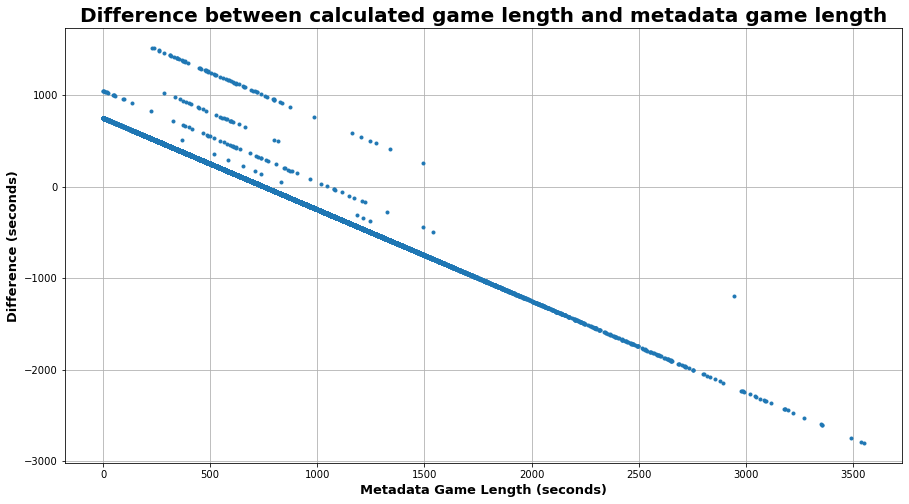

In [81]:
# create a dataframe from the list of results
length_calc_df = pd.DataFrame(
    length_calc_results, 
    columns=[
        'filehash', 
        'game_length', 
        'metadata_gametime', 
        'diff'
    ]
)

# index the dataframe by filehash
length_calc_df.set_index('filehash', inplace=True)

# plot diff as a function of metadata_gametime
plt.figure()
plt.plot(
    length_calc_df['metadata_gametime'],
    length_calc_df['diff'],
    '.'
)
plt.xlabel('Metadata Game Length (seconds)')
plt.ylabel('Difference (seconds)')
plt.title('Difference between calculated game length and metadata game length')
plt.grid()
plt.show() 